In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import sys
sys.path.append('..')

from essentials import make_dir


from models import ResNet18
# from utils import progress_bar

import ipdb
import pickle
import numpy as np
from tqdm import tqdm
import skimage.io as sio

# from tensorboard_logger import Logger
import matplotlib.pyplot as plt

from supervisor.sup_net import SupervisorNetwork

In [12]:

start_epoch = 0

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR100(root='/home/gauravm/.torch/',
                                        train=True, download=True,
                                        transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR100(root='/home/gauravm/.torch/',
                                       train=False, download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False,
                                         num_workers=0)

classes = (
    'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship',
    'truck')

# logger = Logger(os.path.join('../checkpoint', 'sup_multi_soft_b1_o0_q0_l0', 'logs'))

# with open(os.path.join('../checkpoint', 'sup_multi_soft_b1_o0_q0_l0', 'args.pkl'), "wb") as f:
#     pickle.dump(args, f)

# Model
print('==> Building model..')
# net = VGG('VGG19')
net = ResNet18()

checkpoint = torch.load('../res/resnet-18-py3-cifar-100.pth')
net.load_state_dict(checkpoint, strict=False)
net.cuda()
net.eval()

path_dims = [64, 64, 128, 128, 256, 256, 512, 512]
switch_vec = [0, 0, 0, 0, 1, 1, 1, 1]
print('Switch vector {}'.format(switch_vec))

sup_net = SupervisorNetwork(path_dims)

models_dir = os.path.join('../checkpoint', 'sup_100_multi_soft_b1_o0.1_q1_l1_fixed', 'models')

load_epoch = 0
if os.path.exists(models_dir):
    for file in os.listdir(models_dir):
        if file.startswith("sup_net_epoch_"):
            load_epoch = max(load_epoch, int(file.split('_')[3].split('.')[0]))
    if load_epoch > 0:
        load_filename = 'sup_net_epoch_{}.pth'.format(load_epoch)
        print('Loading model {}'.format(load_filename))
        load_path = os.path.join(models_dir, load_filename)
        sup_net.load_state_dict(torch.load(load_path))
else:
    os.makedirs(models_dir)

sup_net.cuda()

bce = nn.BCELoss(reduce=False)
l1 = nn.L1Loss()
mse = nn.MSELoss()

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
Switch vector [0, 0, 0, 0, 1, 1, 1, 1]
Loading model sup_net_epoch_100.pth


In [16]:
def get_s_hist(sup_net):
    s_hist = {}
    sup_net.eval()
    one_hot = torch.zeros((100, 100)).fill_(1).to(device)
    s_one_hot = torch.zeros(100, 100).type(
        torch.cuda.FloatTensor)
    s_queries = torch.from_numpy(np.array(list(range(10)))).to(device)
    s_one_hot = s_one_hot.scatter_(dim=1, index=s_queries.view(-1, 1),
                                   src=one_hot)

    s_vectors_all = sup_net(s_one_hot)

    for k in range(len(switch_vec)):
        if switch_vec[k]:
            s_vectors = s_vectors_all[k]
            for i in range(100):
                s_hist['s_layer_{}_class_{}'.format(k, i)] = s_vectors[i].cpu().data.numpy()
                
    return s_hist

Loading model sup_net_epoch_5.pth
Loading model sup_net_epoch_10.pth
Loading model sup_net_epoch_15.pth
Loading model sup_net_epoch_20.pth
Loading model sup_net_epoch_25.pth
Loading model sup_net_epoch_30.pth
Loading model sup_net_epoch_35.pth
Loading model sup_net_epoch_40.pth
Loading model sup_net_epoch_45.pth


KeyboardInterrupt: 

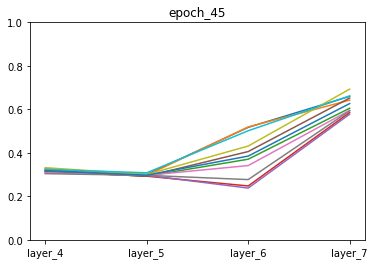

In [14]:
for ep in range(0, 51, 5):
    if ep != 0:
        load_filename = 'sup_net_epoch_{}.pth'.format(ep)
        print('Loading model {}'.format(load_filename))
        load_path = os.path.join(models_dir, load_filename)
        sup_net.load_state_dict(torch.load(load_path))

    sup_net.cuda()
    
    s_hist = get_s_hist(sup_net)

    hist_dict = s_hist
    labels = []
    plots = np.zeros((10, np.sum(switch_vec)))
    count = 0
    for k in range(len(switch_vec)):
        if switch_vec[k]:
            labels.append('layer_{}'.format(k))
            for i in range(10):
                plots[i, count] = np.sum(
                    1 - (hist_dict['s_layer_{}_class_{}'.format(k, i)] > 0.5)) / \
                                  len(hist_dict[
                                          's_layer_{}_class_{}'.format(k, i)])
            count += 1
    plt.figure()
    for i in range(10):
        plt.plot(plots[i], label='{}'.format(classes[i]))
    plt.plot(np.mean(plots, axis=0), label='mean')
    plt.title('epoch_{}'.format(ep))
    plt.xticks(np.arange(plots.shape[1]), labels)
    plt.ylim(0,1)
    # plt.show()

    plot_dir = '../plots/b1_o0_q0.1_l0.1/'
    plt.savefig(os.path.join(plot_dir, 'epoch_{:02d}.png'.format(ep)))
    plt.close()

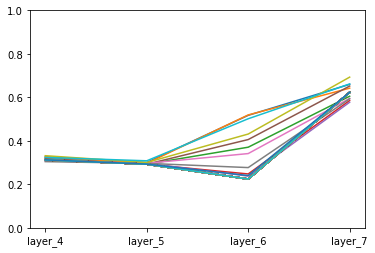

In [21]:
sup_net.cuda()
    
s_hist = get_s_hist(sup_net)

hist_dict = s_hist
labels = []
plots = np.zeros((100, np.sum(switch_vec)))
count = 0
for k in range(len(switch_vec)):
    if switch_vec[k]:
        labels.append('layer_{}'.format(k))
        for i in range(100):
            plots[i, count] = np.sum(1 - (hist_dict['s_layer_{}_class_{}'.format(k, i)]>0.5))/\
                          len(hist_dict['s_layer_{}_class_{}'.format(k, i)])
        count += 1
plt.figure()
for i in range(100):
    plt.plot(plots[i], label='{}'.format(i))
plt.plot(np.mean(plots, axis=0), label='mean')
plt.xticks(np.arange(plots.shape[1]), labels)
plt.ylim(0,1)
# plt.legend()
plt.show()